In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fs = 44100
freqs = np.arange(fs)

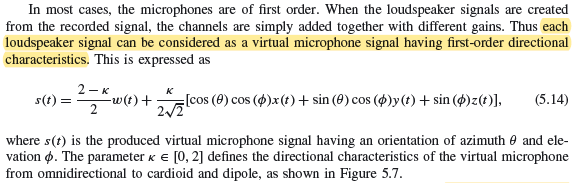

In [3]:
s1 = 2 * ((freqs % 40)/80 - 0.5) * np.minimum(1, np.maximum(0,((freqs % (fs/5)) - fs/10)))
s2 = 2 * ((freqs % 32)/72 - 0.5) * np.minimum(1, np.maximum(0,((freqs + fs/6) % (fs/3)) - fs/6))

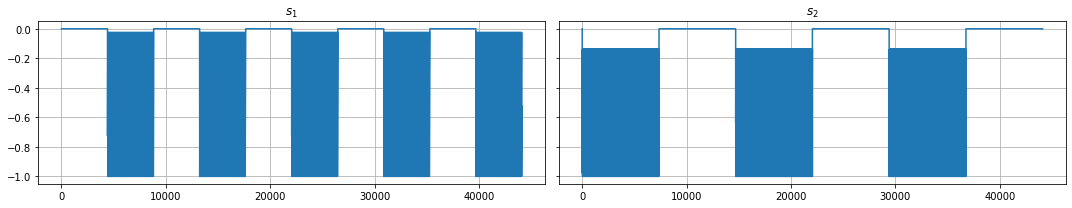

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(15, 3))

plt.subplot(121)
plt.plot(s1)
plt.title(r'$s_1$')
plt.grid(True)
plt.tight_layout()

plt.subplot(122)
plt.plot(s2)
plt.title(r'$s_2$')
plt.grid(True)
plt.tight_layout()

In [5]:
theta1 = 50
theta2 = -170

w = (s1 + s2) / np.sqrt(2)
x = s1 * np.cos(theta1 / 180 * np.pi) + s2 * np.cos(theta2 / 180 * np.pi)
y = s1 * np.sin(theta1 / 180 * np.pi) + s2 * np.sin(theta2 / 180 * np.pi)

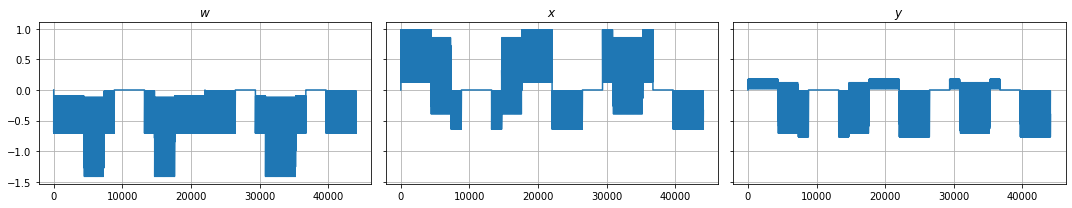

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(15, 3))

plt.subplot(131)
plt.plot(w)
plt.title(r'$w$')
plt.grid(True)
plt.tight_layout()

plt.subplot(132)
plt.plot(x)
plt.title(r'$x$')
plt.grid(True)
plt.tight_layout()

plt.subplot(133)
plt.plot(y)
plt.title(r'$y$')
plt.grid(True)
plt.tight_layout()

In [7]:
# Add fading in diffuse noise with  36 sources evenly in the horizontal plane
# Each direction will produce a different source
for direction in range(0, 360, 10):
    noise = (np.random.rand(fs) - 0.5) * (10 ** ((freqs / fs) * 2))
    w += noise / np.sqrt(2)
    x += noise * np.cos(direction / 180 * np.pi)
    y += noise * np.sin(direction / 180 * np.pi)

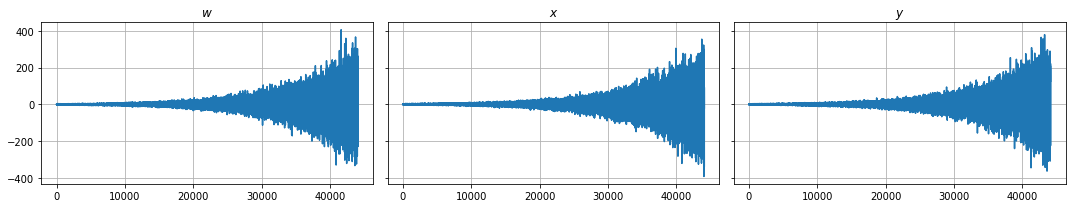

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey='row', figsize=(15, 3))

plt.subplot(131)
plt.plot(w)
plt.title(r'$w$')
plt.grid(True)
plt.tight_layout()

plt.subplot(132)
plt.plot(x)
plt.title(r'$x$')
plt.grid(True)
plt.tight_layout()

plt.subplot(133)
plt.plot(y)
plt.title(r'$y$')
plt.grid(True)
plt.tight_layout()

In [9]:
hopsize = 256
winsize = 512 
i = 2 
alpha = 1. / (0.02 * fs / winsize)

rho = 1
c = 343

In [10]:
iterable = range(0, (len(x) - winsize), hopsize)
intensity = np.zeros((hopsize, 2)) + np.finfo(float).eps
energy = np.zeros((hopsize, len(iterable))) + np.finfo(float).eps
azimuth = np.zeros((hopsize, len(iterable))) + np.finfo(float).eps
diffuseness = np.zeros((hopsize, len(iterable))) + np.finfo(float).eps

In [11]:
for i, time in enumerate(iterable):
    W = np.fft.fft(w[time : (time + winsize)] * np.hanning(winsize))
    X = np.fft.fft(x[time : (time + winsize)] * np.hanning(winsize))
    Y = np.fft.fft(y[time : (time + winsize)] * np.hanning(winsize))
    W = W[:hopsize]
    X = X[:hopsize]
    Y = Y[:hopsize]
    U = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1) # hopsize x 2
    P_ = np.repeat(np.conjugate(W).reshape(-1, 1), 1, axis=1) * np.sqrt(2) # hopsize x 2

    temp_intensity = np.real(P_ * U)
    intensity = temp_intensity * alpha + intensity * (1 - alpha)

    azimuth[:, i] = np.around(np.arctan2(intensity[:, 1], intensity[:, 0]) * (180/np.pi)) # hopsize x _

    temp_energy = (1 / 4) * (rho * np.sum(np.absolute(U) ** 2, axis=1) \
                + (1 / (rho * (c ** 2))) * np.absolute(W * np.sqrt(2)) ** 2 \
                + np.finfo(float).eps)
    energy[:, i] = temp_energy * alpha + energy[:, (i - 1)] * (1 - alpha)

    diffuseness[:, i] = 1 - np.sqrt(np.sum(intensity ** 2, axis=1)) / (c * energy[:, i])

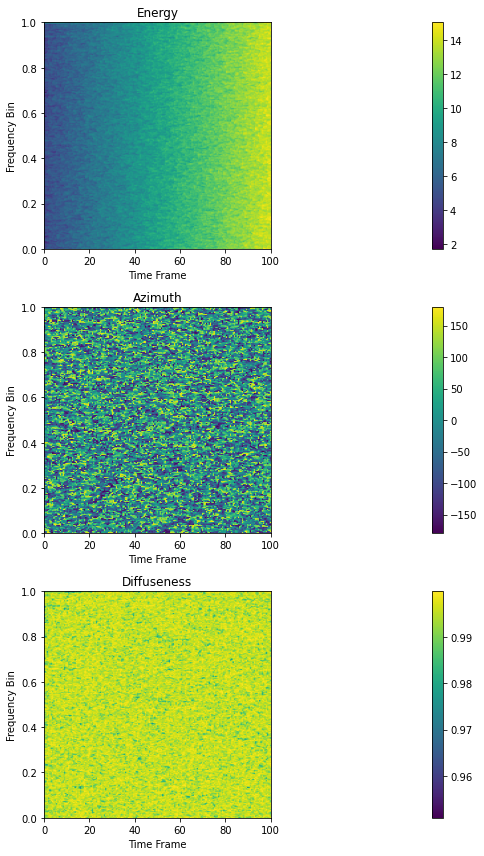

In [15]:
plt.figure(figsize=(45, 12))

plt.subplot(311)
plt.imshow(np.log(energy), extent=[0, 100, 0, 1], aspect=100)
plt.title('Energy')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.colorbar()
plt.tight_layout()

plt.subplot(312)
plt.imshow(azimuth, extent=[0, 100, 0, 1], aspect=100)
plt.title('Azimuth')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.colorbar()
plt.tight_layout()

plt.subplot(313)
plt.imshow(diffuseness, extent=[0, 100, 0, 1], aspect=100)
plt.title('Diffuseness')
plt.xlabel('Time Frame')
plt.ylabel('Frequency Bin')
plt.colorbar()
plt.tight_layout()

plt.show()